<a href="https://colab.research.google.com/github/27hdu/Heart-Disease-Risk-Prediction-Using-Supervised-ML-Models/blob/main/ClevelandFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving heart_cleveland_upload.csv to heart_cleveland_upload.csv


In [ ]:
df=pd.read_csv('heart_cleveland_upload.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0


In [ ]:
print("DataFrame shape:", df.shape)

DataFrame shape: (297, 14)


In [ ]:

cont_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

outlier_indices = []
for col in cont_features:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_indices.extend(outliers.index.tolist())
    print(f"Feature '{col}': found {len(outliers)} outliers")

outlier_indices = list(set(outlier_indices))

Feature 'age': found 0 outliers
Feature 'trestbps': found 9 outliers
Feature 'chol': found 5 outliers
Feature 'thalach': found 1 outliers
Feature 'oldpeak': found 5 outliers


In [ ]:
df_no_outliers = df.drop(index=outlier_indices).copy()

print(f"Removed {len(outlier_indices)} rows containing outliers.")
print(f"Final dataset shape: {df_no_outliers.shape}")


Removed 19 rows containing outliers.
Final dataset shape: (278, 14)


In [ ]:
print(df_no_outliers.describe())

              age         sex          cp    trestbps        chol         fbs  \
count  278.000000  278.000000  278.000000  278.000000  278.000000  278.000000   
mean    54.172662    0.694245    2.133094  129.949640  243.147482    0.136691   
std      9.136690    0.461558    0.968969   15.598215   44.900972    0.344140   
min     29.000000    0.000000    0.000000   94.000000  126.000000    0.000000   
25%     47.000000    0.000000    1.250000  120.000000  211.000000    0.000000   
50%     55.000000    1.000000    2.000000  130.000000  240.000000    0.000000   
75%     60.750000    1.000000    3.000000  140.000000  272.500000    0.000000   
max     77.000000    1.000000    3.000000  170.000000  360.000000    1.000000   

          restecg     thalach       exang     oldpeak       slope          ca  \
count  278.000000  278.000000  278.000000  278.000000  278.000000  278.000000   
mean     0.985612  150.000000    0.316547    0.963669    0.571942    0.651079   
std      0.998089   22.7281

In [ ]:
# Age bins
df_no_outliers['age_cat'] = pd.cut(
    df_no_outliers['age'],
    bins=[0, 45, 55, 65, 100],
    labels=[0, 1, 2, 3]
)


In [ ]:
# trestbps bins
df_no_outliers['trestbps_cat'] = pd.cut(
    df_no_outliers['trestbps'],
    bins=[0, 120, 140, df_no_outliers['trestbps'].max()],
    labels=[0, 1, 2]
)

In [ ]:
# chol bins
df_no_outliers['chol_cat'] = pd.cut(
    df_no_outliers['chol'],
    bins=[0, 200, 240, df_no_outliers['chol'].max()],
    labels=[0, 1, 2]
)

In [ ]:
# thalach bins
df_no_outliers['thalach_cat'] = pd.cut(
    df_no_outliers['thalach'],
    bins=[0, 120, 150, df_no_outliers['thalach'].max()],
    labels=[0, 1, 2]
)

In [ ]:
# oldpeak bins
q1, q2, q3 = df_no_outliers['oldpeak'].quantile([0.25, 0.5, 0.75])
df_no_outliers['oldpeak_cat'] = pd.cut(
    df_no_outliers['oldpeak'],
    bins=[-0.01, q1, q2, q3, df_no_outliers['oldpeak'].max()],
    labels=[0, 1, 2, 3]
)

In [ ]:
print(df_no_outliers.head())

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   69    1   0       160   234    1        2      131      0      0.1      1   
1   69    0   0       140   239    0        0      151      0      1.8      0   
2   66    0   0       150   226    0        0      114      0      2.6      2   
3   65    1   0       138   282    1        2      174      0      1.4      1   
4   64    1   0       110   211    0        2      144      1      1.8      1   

   ca  thal  condition age_cat trestbps_cat chol_cat thalach_cat oldpeak_cat  
0   1     0          0       3            2        1           1           1  
1   2     0          0       3            1        1           2           3  
2   0     0          0       3            2        1           0           3  
3   1     0          1       2            1        2           2           2  
4   0     0          0       2            0        1           1           3  


In [ ]:
cols_to_drop = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
df_no_outliers.drop(columns=cols_to_drop, inplace=True)

print(df_no_outliers.head())


   sex  cp  fbs  restecg  exang  slope  ca  thal  condition age_cat  \
0    1   0    1        2      0      1   1     0          0       3   
1    0   0    0        0      0      0   2     0          0       3   
2    0   0    0        0      0      2   0     0          0       3   
3    1   0    1        2      0      1   1     0          1       2   
4    1   0    0        2      1      1   0     0          0       2   

  trestbps_cat chol_cat thalach_cat oldpeak_cat  
0            2        1           1           1  
1            1        1           2           3  
2            2        1           0           3  
3            1        2           2           2  
4            0        1           1           3  


In [ ]:
pip install kmodes

In [ ]:
from kmodes.kmodes import KModes

In [ ]:
male_df = df_no_outliers[df_no_outliers["sex"] == 1].copy()
female_df = df_no_outliers[df_no_outliers["sex"] == 0].copy()

In [ ]:
def plot_kmodes_elbow(df, max_k=5, title="Elbow Method"):
    cost = []
    K = range(1, max_k + 1)
    for k in K:
        km = KModes(n_clusters=k, init='Huang', n_init=5, verbose=0)
        km.fit_predict(df)
        cost.append(km.cost_)
    plt.figure(figsize=(6, 4))
    plt.plot(K, cost, 'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Cost')
    plt.title(title)
    plt.show()


🔹 Elbow curve for Male dataset:


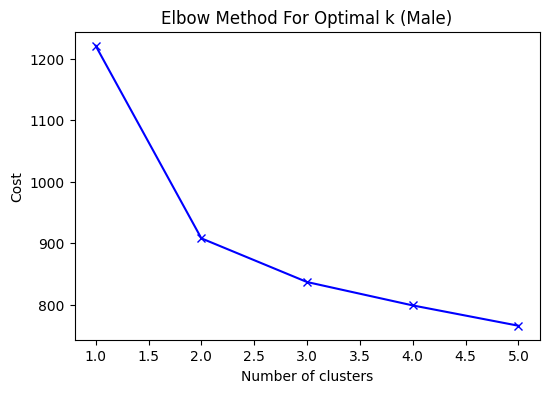


🔹 Elbow curve for Female dataset:


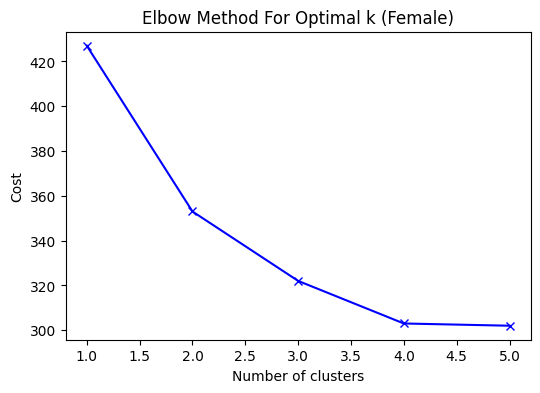

In [ ]:
print("\n🔹 Elbow curve for Male dataset:")
plot_kmodes_elbow(
    male_df.drop(columns=["sex"]),
    max_k=5,
    title="Elbow Method For Optimal k (Male)"
)

print("\n🔹 Elbow curve for Female dataset:")
plot_kmodes_elbow(
    female_df.drop(columns=["sex"]),
    max_k=5,
    title="Elbow Method For Optimal k (Female)"
)


In [ ]:
km_male = KModes(n_clusters=2, init='Huang', n_init=5, verbose=0)
male_clusters = km_male.fit_predict(male_df.drop(columns=["sex"]))
male_df["Cluster"] = male_clusters

km_female = KModes(n_clusters=3, init='Huang', n_init=5, verbose=0)
female_clusters = km_female.fit_predict(female_df.drop(columns=["sex"]))
female_df["Cluster"] = female_clusters

In [ ]:
print("Male cluster sizes:\n", male_df["Cluster"].value_counts().sort_index())
print("\nFemale cluster sizes:\n", female_df["Cluster"].value_counts().sort_index())


Male cluster sizes:
 Cluster
0    106
1     87
Name: count, dtype: int64

Female cluster sizes:
 Cluster
0    34
1    27
2    24
Name: count, dtype: int64


In [ ]:
for c in sorted(male_df["Cluster"].unique()):
    print(f"\n=== Male Cluster {c} profile ===")
    display(male_df[male_df["Cluster"] == c].describe(include='all'))



=== Male Cluster 0 profile ===


,sex,cp,fbs,restecg,exang,slope,ca,thal,condition,age_cat,trestbps_cat,chol_cat,thalach_cat,oldpeak_cat,Cluster
count,106.0,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.0,106.0,106.0,106.0,106.0,106.0
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.0,3.0,3.0,4.0,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,2.0,1.0,3.0,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.0,46.0,58.0,57.0,50.0,NaN
mean,1.0,2.500000,0.141509,1.283019,0.594340,0.858491,1.028302,1.490566,0.858491,NaN,NaN,NaN,NaN,NaN,0.0
std,0.0,0.948683,0.350202,0.963671,0.493352,0.505940,0.999596,0.795766,0.350202,NaN,NaN,NaN,NaN,NaN,0.0
min,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.0
25%,1.0,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,0.0
50%,1.0,3.000000,0.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,NaN,NaN,NaN,NaN,NaN,0.0
75%,1.0,3.000000,0.000000,2.000000,1.000000,1.000000,2.000000,2.000000,1.000000,NaN,NaN,NaN,NaN,NaN,0.0



=== Male Cluster 1 profile ===


,sex,cp,fbs,restecg,exang,slope,ca,thal,condition,age_cat,trestbps_cat,chol_cat,thalach_cat,oldpeak_cat,Cluster
count,87.0,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.0,87.0,87.0,87.0,87.0,87.0
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.0,3.0,3.0,4.0,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,2.0,0.0,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.0,42.0,43.0,74.0,49.0,NaN
mean,1.0,1.758621,0.160920,0.712644,0.103448,0.275862,0.367816,0.528736,0.172414,NaN,NaN,NaN,NaN,NaN,1.0
std,0.0,0.927180,0.369587,0.963376,0.306309,0.584483,0.733183,0.873899,0.379930,NaN,NaN,NaN,NaN,NaN,0.0
min,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,1.0
25%,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,1.0
50%,1.0,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,1.0
75%,1.0,2.000000,0.000000,2.000000,0.000000,0.000000,0.500000,1.500000,0.000000,NaN,NaN,NaN,NaN,NaN,1.0


In [ ]:
for c in sorted(female_df["Cluster"].unique()):
    print(f"\n=== Female Cluster {c} profile ===")
    display(female_df[female_df["Cluster"] == c].describe(include='all'))



=== Female Cluster 0 profile ===


,sex,cp,fbs,restecg,exang,slope,ca,thal,condition,age_cat,trestbps_cat,chol_cat,thalach_cat,oldpeak_cat,Cluster
count,34.0,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.0,34.000000,34.0,34.0,34.0,34.0,34.0,34.0
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.0,3.0,2.0,4.0,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,2.0,2.0,0.0,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,22.0,27.0,30.0,18.0,NaN
mean,0.0,1.764706,0.147059,1.529412,0.117647,0.352941,0.441176,0.0,0.147059,NaN,NaN,NaN,NaN,NaN,0.0
std,0.0,0.854891,0.359491,0.861123,0.327035,0.597081,0.704581,0.0,0.359491,NaN,NaN,NaN,NaN,NaN,0.0
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,0.0
25%,0.0,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,0.0
50%,0.0,2.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,0.0
75%,0.0,2.000000,0.000000,2.000000,0.000000,1.000000,1.000000,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,0.0



=== Female Cluster 1 profile ===


,sex,cp,fbs,restecg,exang,slope,ca,thal,condition,age_cat,trestbps_cat,chol_cat,thalach_cat,oldpeak_cat,Cluster
count,27.0,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.0,27.0,27.0,27.0,27.0,27.0
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.0,3.0,3.0,4.0,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,2.0,1.0,1.0,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,14.0,18.0,18.0,10.0,NaN
mean,0.0,2.777778,0.111111,0.740741,0.407407,0.814815,0.703704,0.703704,0.481481,NaN,NaN,NaN,NaN,NaN,1.0
std,0.0,0.423659,0.320256,0.944319,0.500712,0.395847,1.030863,0.953327,0.509175,NaN,NaN,NaN,NaN,NaN,0.0
min,0.0,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,1.0
25%,0.0,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,1.0
50%,0.0,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,1.0
75%,0.0,3.000000,0.000000,2.000000,1.000000,1.000000,1.500000,2.000000,1.000000,NaN,NaN,NaN,NaN,NaN,1.0



=== Female Cluster 2 profile ===


,sex,cp,fbs,restecg,exang,slope,ca,thal,condition,age_cat,trestbps_cat,chol_cat,thalach_cat,oldpeak_cat,Cluster
count,24.0,24.000000,24.000000,24.000000,24.000000,24.000000,24.00000,24.0,24.0,24.0,24.0,24.0,24.0,24.0,24.0
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.0,3.0,3.0,4.0,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,2.0,0.0,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,15.0,14.0,20.0,14.0,NaN
mean,0.0,1.666667,0.041667,0.166667,0.041667,0.416667,0.25000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2.0
std,0.0,0.816497,0.204124,0.564660,0.204124,0.583592,0.53161,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2.0
25%,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2.0
50%,0.0,2.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2.0
75%,0.0,2.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2.0


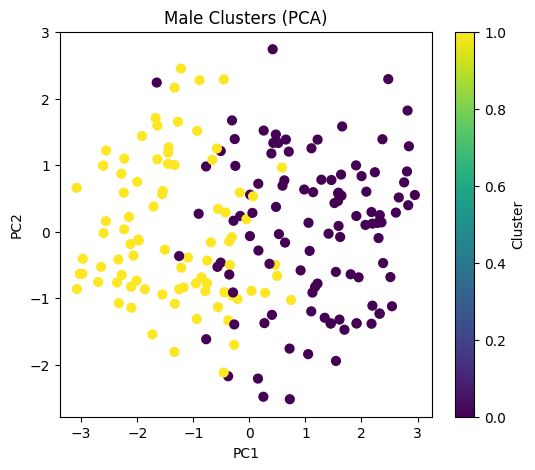

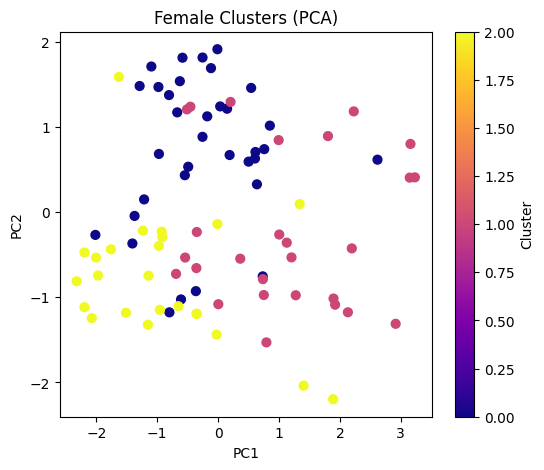

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Male plot
pca = PCA(n_components=2)
male_pca = pca.fit_transform(male_df.drop(columns=["Cluster", "sex"]))
plt.figure(figsize=(6, 5))
plt.scatter(male_pca[:,0], male_pca[:,1], c=male_df["Cluster"], cmap="viridis", s=40)
plt.title("Male Clusters (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster")
plt.show()

# Female plot
pca = PCA(n_components=2)
female_pca = pca.fit_transform(female_df.drop(columns=["Cluster", "sex"]))
plt.figure(figsize=(6, 5))
plt.scatter(female_pca[:,0], female_pca[:,1], c=female_df["Cluster"], cmap="plasma", s=40)
plt.title("Female Clusters (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster")
plt.show()


In [ ]:
print("\nMale cluster condition rates:")
print(male_df.groupby("Cluster")["condition"].mean())

print("\nFemale cluster condition rates:")
print(female_df.groupby("Cluster")["condition"].mean())



Male cluster condition rates:
Cluster
0    0.858491
1    0.172414
Name: condition, dtype: float64

Female cluster condition rates:
Cluster
0    0.147059
1    0.481481
2    0.000000
Name: condition, dtype: float64


In [ ]:
binned_cols = ['trestbps_cat', 'chol_cat', 'thalach_cat', 'oldpeak_cat']

for col in binned_cols:
    df_final[col] = df_final[col].astype(int)


Number of numeric features: 14


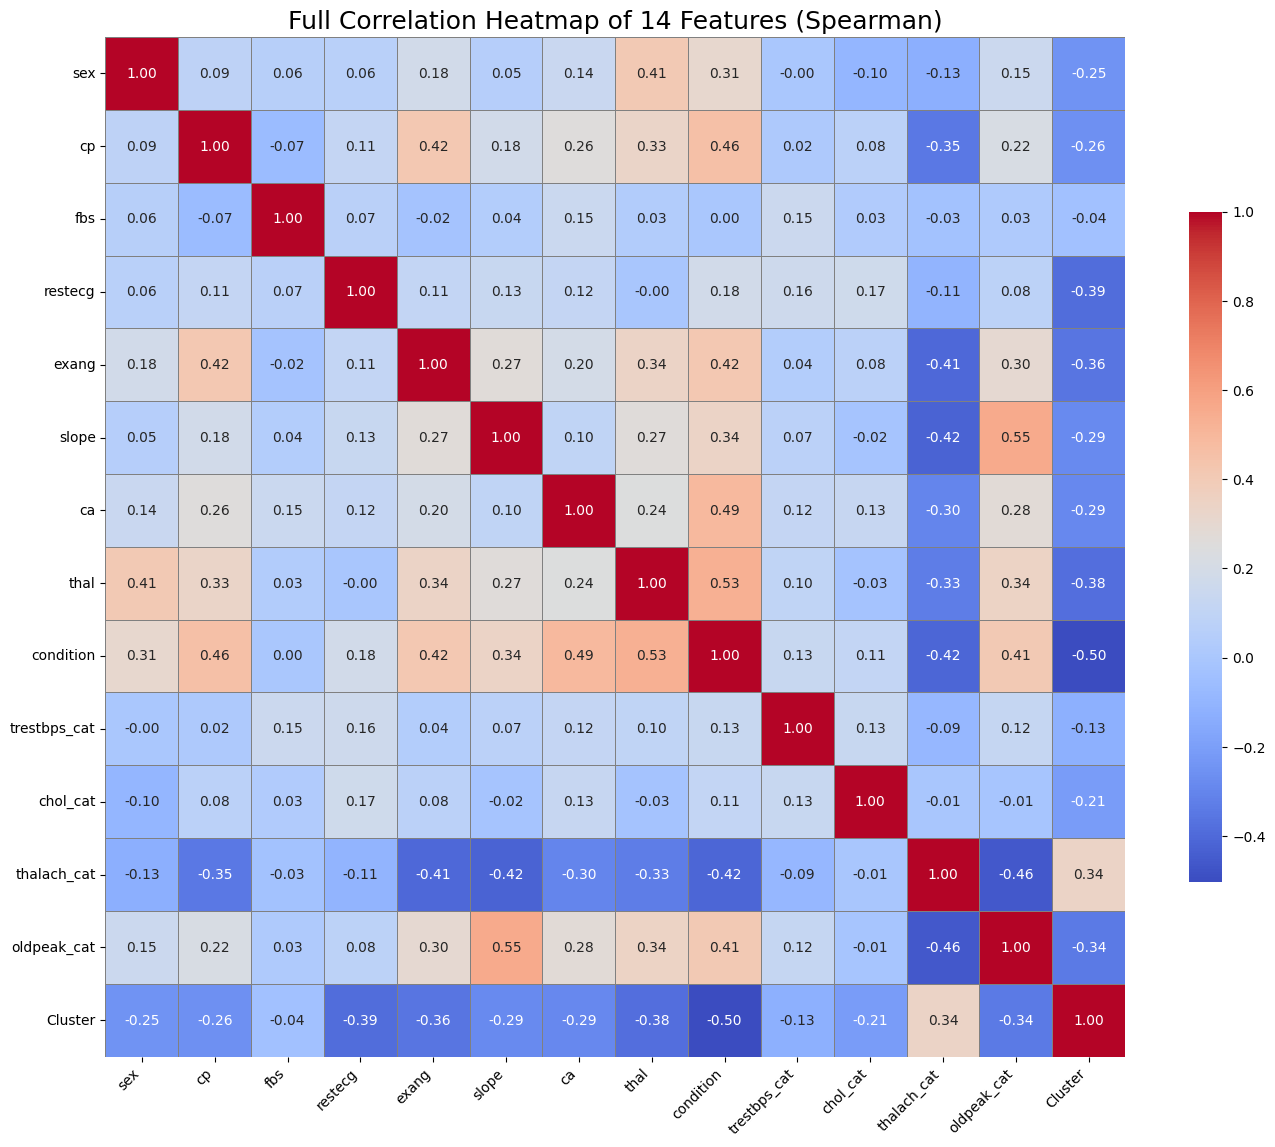

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df_numeric = df_final.select_dtypes(include='number')

print(f"Number of numeric features: {df_numeric.shape[1]}")

corr_matrix = df_numeric.corr(method='spearman')

# Plot heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    cbar_kws={'shrink': 0.6},
    linewidths=0.5,
    linecolor='gray'
)
plt.title("Full Correlation Heatmap of 14 Features (Spearman)", fontsize=18)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
X = combined_df.drop(columns=["cardio", "Cluster"])

y = combined_df["cardio"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_no_outliers.drop(columns='condition'),
    df_no_outliers['condition'],
    stratify=df_no_outliers['condition'],
    test_size=0.2,
    random_state=42
)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"Before SMOTE: {y_train.value_counts().to_dict()}")
print(f"After SMOTE: {y_train_smote.value_counts().to_dict()}")


Before SMOTE: {0: 123, 1: 99}
After SMOTE: {0: 123, 1: 123}


In [ ]:
if 'Cluster' in df_final.columns:
    df_final = df_final.drop(columns=['Cluster'])
)
X = df_final.drop(columns=['condition'])
y = df_final['condition']


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)


Training set shape: (222, 13) (222,)
Test set shape: (56, 13) (56,)


In [ ]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
X_train_enc = encoder.fit_transform(X_train)
X_test_enc = encoder.transform(X_test)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="weighted", zero_division=0)
    rec = recall_score(y_true, y_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0)
    print(f"\n📊 {model_name} Results:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")


In [ ]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_train_enc, y_train)
dtree_preds = dtree.predict(X_test_enc)
evaluate_model(y_test, dtree_preds, "Decision Tree")



📊 Decision Tree Results:
Accuracy:  0.7679
Precision: 0.7683
Recall:    0.7679
F1-score:  0.7658


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=500, max_depth=4, random_state=42
)
rf.fit(X_train_enc, y_train)
rf_preds = rf.predict(X_test_enc)
evaluate_model(y_test, rf_preds, "Random Forest")


📊 Random Forest Results:
Accuracy:  0.7857
Precision: 0.8055
Recall:    0.7857
F1-score:  0.7776


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='most_frequent')
X_train_imputed = imputer.fit_transform(X_train_enc)
X_test_imputed = imputer.transform(X_test_enc)


mlp = MLPClassifier(
    hidden_layer_sizes=(50, 30), max_iter=300, random_state=42
)
mlp.fit(X_train_imputed, y_train)
mlp_preds = mlp.predict(X_test_imputed)
evaluate_model(y_test, mlp_preds, "Multilayer Perceptron")


📊 Multilayer Perceptron Results:
Accuracy:  0.7321
Precision: 0.7502
Recall:    0.7321
F1-score:  0.7197


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    learning_rate=0.1,
    n_estimators=100,
    max_depth=4,
    use_label_encoder=False,
    eval_metric="mlogloss",
    random_state=42
)
xgb.fit(X_train_enc, y_train)
xgb_preds = xgb.predict(X_test_enc)
evaluate_model(y_test, xgb_preds, "XGBoost")



📊 XGBoost Results:
Accuracy:  0.7857
Precision: 0.8055
Recall:    0.7857
F1-score:  0.7776


In [ ]:
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='most_frequent')
X_train_imputed = imputer.fit_transform(X_train_enc)
X_test_imputed = imputer.transform(X_test_enc)

svm = SVC(probability=True, random_state=42)
svm.fit(X_train_imputed, y_train)
svm_preds = svm.predict(X_test_imputed)
svm_probs = svm.predict_proba(X_test_imputed)[:, 1]

evaluate_model(y_test, svm_preds, "SVM")



📊 SVM Results:
Accuracy:  0.8036
Precision: 0.8193
Recall:    0.8036
F1-score:  0.7975


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='most_frequent')
X_train_imputed = imputer.fit_transform(X_train_enc)
X_test_imputed = imputer.transform(X_test_enc)

logreg = LogisticRegression(max_iter=500, random_state=42)
logreg.fit(X_train_imputed, y_train)
logreg_preds = logreg.predict(X_test_imputed)
logreg_probs = logreg.predict_proba(X_test_imputed)[:, 1]

evaluate_model(y_test, logreg_preds, "Logistic Regression")


📊 Logistic Regression Results:
Accuracy:  0.8214
Precision: 0.8460
Recall:    0.8214
F1-score:  0.8146


In [ ]:
importances = rf.feature_importances_
feature_names = X.columns

for name, importance in sorted(zip(feature_names, importances), key=lambda x: -x[1]):
    print(f"{name}: {importance:.4f}")

thal: 0.1875
ca: 0.1800
cp: 0.1362
oldpeak_cat: 0.1171
exang: 0.0957
thalach_cat: 0.0715
slope: 0.0662
age_cat: 0.0452
sex: 0.0434
trestbps_cat: 0.0172
chol_cat: 0.0169
restecg: 0.0146
fbs: 0.0086


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curve(y_true, y_probs, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')


In [ ]:
from sklearn.metrics import classification_report

def detailed_report(y_true, y_pred, model_name):
    print(f"\n📑 Classification Report for {model_name}:")
    print(classification_report(y_true, y_pred, target_names=["No Cardio", "Cardio"]))


In [ ]:
dtree_probs = dtree.predict_proba(X_test_enc)[:, 1]
detailed_report(y_test, dtree_preds, "Decision Tree")



📑 Classification Report for Decision Tree:
              precision    recall  f1-score   support

   No Cardio       0.76      0.84      0.80        31
      Cardio       0.77      0.68      0.72        25

    accuracy                           0.77        56
   macro avg       0.77      0.76      0.76        56
weighted avg       0.77      0.77      0.77        56



In [ ]:
svm_probs = svm.predict_proba(X_test_enc)[:, 1]
detailed_report(y_test, svm_preds, "SVM")


📑 Classification Report for SVM:
              precision    recall  f1-score   support

   No Cardio       0.76      0.94      0.84        31
      Cardio       0.89      0.64      0.74        25

    accuracy                           0.80        56
   macro avg       0.83      0.79      0.79        56
weighted avg       0.82      0.80      0.80        56



In [ ]:
logreg_probs = logreg.predict_proba(X_test_enc)[:, 1]
detailed_report(y_test, logreg_preds, "Logistic Regression")


📑 Classification Report for Logistic Regression:
              precision    recall  f1-score   support

   No Cardio       0.77      0.97      0.86        31
      Cardio       0.94      0.64      0.76        25

    accuracy                           0.82        56
   macro avg       0.86      0.80      0.81        56
weighted avg       0.85      0.82      0.81        56



In [ ]:
rf_probs = rf.predict_proba(X_test_enc)[:, 1]
detailed_report(y_test, rf_preds, "Random Forest")



📑 Classification Report for Random Forest:
              precision    recall  f1-score   support

   No Cardio       0.74      0.94      0.83        31
      Cardio       0.88      0.60      0.71        25

    accuracy                           0.79        56
   macro avg       0.81      0.77      0.77        56
weighted avg       0.81      0.79      0.78        56



In [ ]:
mlp_probs = mlp.predict_proba(X_test_enc)[:, 1]
detailed_report(y_test, mlp_preds, "Multilayer Perceptron")



📑 Classification Report for Multilayer Perceptron:
              precision    recall  f1-score   support

   No Cardio       0.70      0.90      0.79        31
      Cardio       0.81      0.52      0.63        25

    accuracy                           0.73        56
   macro avg       0.76      0.71      0.71        56
weighted avg       0.75      0.73      0.72        56



In [ ]:
xgb_probs = xgb.predict_proba(X_test_enc)[:, 1]
detailed_report(y_test, xgb_preds, "XGBoost")



📑 Classification Report for XGBoost:
              precision    recall  f1-score   support

   No Cardio       0.74      0.94      0.83        31
      Cardio       0.88      0.60      0.71        25

    accuracy                           0.79        56
   macro avg       0.81      0.77      0.77        56
weighted avg       0.81      0.79      0.78        56



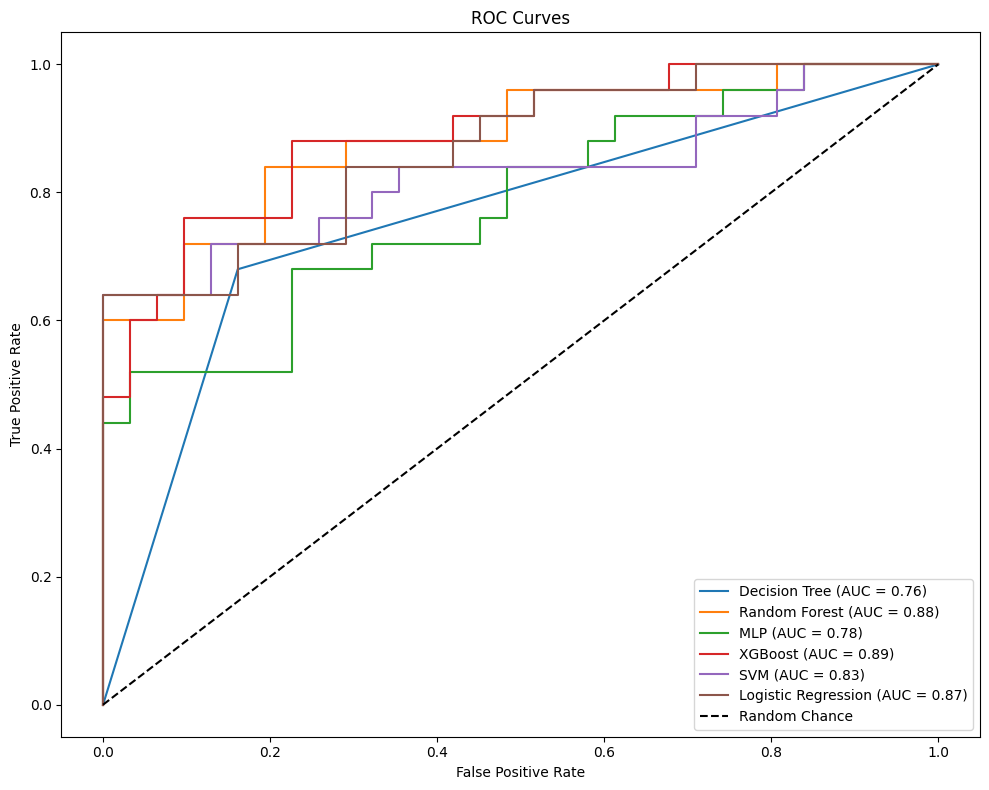

In [ ]:
plt.figure(figsize=(10, 8))

# Existing models
plot_roc_curve(y_test, dtree_probs, "Decision Tree")
plot_roc_curve(y_test, rf_probs, "Random Forest")
plot_roc_curve(y_test, mlp_probs, "MLP")
plot_roc_curve(y_test, xgb_probs, "XGBoost")

# New models
plot_roc_curve(y_test, svm_probs, "SVM")
plot_roc_curve(y_test, logreg_probs, "Logistic Regression")

# Diagonal reference line
plt.plot([0, 1], [0, 1], "k--", label="Random Chance")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
dtree_params = {
    "max_depth": [3, 5, 7, None],
    "min_samples_split": [2, 5, 10],
    "criterion": ["gini", "entropy"],
}

dtree_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    dtree_params,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
)
dtree_grid.fit(X_train_enc, y_train)

print("✅ Best Decision Tree Params:", dtree_grid.best_params_)
dtree_best = dtree_grid.best_estimator_
evaluate_model(y_test, dtree_best.predict(X_test_enc), "Tuned Decision Tree")


✅ Best Decision Tree Params: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 10}

📊 Tuned Decision Tree Results:
Accuracy:  0.7500
Precision: 0.7514
Recall:    0.7500
F1-score:  0.7467


In [ ]:
rf_params = {
    "n_estimators": [100, 300, 500],
    "max_depth": [4, 6, 8],
    "min_samples_split": [2, 5],
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_params,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
)
rf_grid.fit(X_train_enc, y_train)

print("✅ Best Random Forest Params:", rf_grid.best_params_)
rf_best = rf_grid.best_estimator_
evaluate_model(y_test, rf_best.predict(X_test_enc), "Tuned Random Forest")


✅ Best Random Forest Params: {'max_depth': 8, 'min_samples_split': 5, 'n_estimators': 500}

📊 Tuned Random Forest Results:
Accuracy:  0.8036
Precision: 0.8193
Recall:    0.8036
F1-score:  0.7975


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV

mlp_params = {
    "hidden_layer_sizes": [(50,), (50, 30), (100,)],
    "activation": ["relu", "tanh"],
    "alpha": [0.0001, 0.001],
}

imputer = SimpleImputer(strategy='most_frequent')
X_train_imputed = imputer.fit_transform(X_train_enc)

mlp_grid = GridSearchCV(
    MLPClassifier(max_iter=300, random_state=42),
    mlp_params,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
)
mlp_grid.fit(X_train_imputed, y_train)

print("✅ Best MLP Params:", mlp_grid.best_params_)
mlp_best = mlp_grid.best_estimator_


X_test_imputed = imputer.transform(X_test_enc)
evaluate_model(y_test, mlp_best.predict(X_test_imputed), "Tuned MLP")

✅ Best MLP Params: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}

📊 Tuned MLP Results:
Accuracy:  0.8393
Precision: 0.8754
Recall:    0.8393
F1-score:  0.8318


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
xgb_params = {
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 4, 6],
    "n_estimators": [100, 300],
}

xgb_grid = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    xgb_params,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
)
xgb_grid.fit(X_train_enc, y_train)

print("✅ Best XGBoost Params:", xgb_grid.best_params_)
xgb_best = xgb_grid.best_estimator_
evaluate_model(y_test, xgb_best.predict(X_test_enc), "Tuned XGBoost")


✅ Best XGBoost Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}

📊 Tuned XGBoost Results:
Accuracy:  0.8214
Precision: 0.8460
Recall:    0.8214
F1-score:  0.8146


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:54:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV

logreg_params = {
    "C": [0.01, 0.1, 1, 10],
    "penalty": ["l1", "l2"],
    "solver": ["liblinear"],
}

imputer = SimpleImputer(strategy='most_frequent')
X_train_imputed = imputer.fit_transform(X_train_enc)

logreg_grid = GridSearchCV(
    LogisticRegression(max_iter=500, random_state=42),
    logreg_params,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
)
logreg_grid.fit(X_train_imputed, y_train)

print("✅ Best Logistic Regression Params:", logreg_grid.best_params_)
logreg_best = logreg_grid.best_estimator_

X_test_imputed = imputer.transform(X_test_enc)
evaluate_model(y_test, logreg_best.predict(X_test_imputed), "Tuned Logistic Regression")

✅ Best Logistic Regression Params: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}

📊 Tuned Logistic Regression Results:
Accuracy:  0.8214
Precision: 0.8460
Recall:    0.8214
F1-score:  0.8146


In [ ]:
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="weighted", zero_division=0)
    rec = recall_score(y_true, y_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0)
    print(f"\n📊 {model_name} Results:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")

svm_params = {
    "C": [0.1, 1, 10],
    "kernel": ["linear", "rbf"],
}

imputer = SimpleImputer(strategy='most_frequent')
X_train_imputed = imputer.fit_transform(X_train_enc)
X_test_imputed = imputer.transform(X_test_enc)

svm_grid = GridSearchCV(
    SVC(probability=True, random_state=42),
    svm_params,
    cv=3,
    scoring="accuracy",
    n_jobs=-1,
)
svm_grid.fit(X_train_imputed, y_train)

print("✅ Best SVM Params:", svm_grid.best_params_)
svm_best = svm_grid.best_estimator_

evaluate_model(y_test, svm_best.predict(X_test_imputed), "Tuned SVM")

✅ Best SVM Params: {'C': 0.1, 'kernel': 'rbf'}

📊 Tuned SVM Results:
Accuracy:  0.8214
Precision: 0.8650
Recall:    0.8214
F1-score:  0.8115


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

dtree_probs = dtree_best.predict_proba(X_test_enc)[:, 1]
rf_probs = rf_best.predict_proba(X_test_enc)[:, 1]
mlp_probs = mlp_best.predict_proba(X_test_enc)[:, 1]
xgb_probs = xgb_best.predict_proba(X_test_enc)[:, 1]
svm_probs = svm_best.predict_proba(X_test_enc)[:,1]
logreg_probs = logreg_best.predict_proba(X_test_enc)[:, 1]


In [ ]:
def plot_model_roc(y_true, y_probs, label):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{label} (AUC = {roc_auc:.2f})")


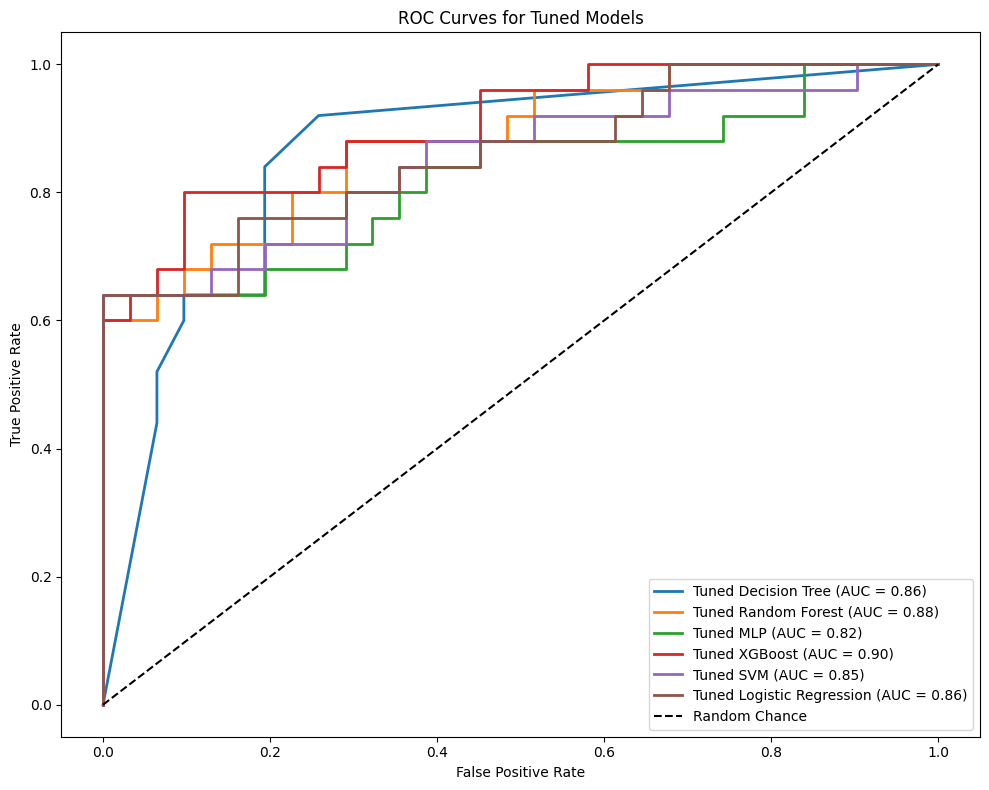

In [ ]:
plt.figure(figsize=(10, 8))

plot_model_roc(y_test, dtree_probs, "Tuned Decision Tree")
plot_model_roc(y_test, rf_probs, "Tuned Random Forest")
plot_model_roc(y_test, mlp_probs, "Tuned MLP")
plot_model_roc(y_test, xgb_probs, "Tuned XGBoost")
plot_model_roc(y_test, svm_probs, "Tuned SVM")
plot_model_roc(y_test, logreg_probs, "Tuned Logistic Regression")

# reference line
plt.plot([0, 1], [0, 1], "k--", label="Random Chance")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Tuned Models")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


In [ ]:
%pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=a97136c2f5fcd1a304de48b52e65828acc2fb2a18ff555a64036241268bd76af
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train_imputed,
    feature_names=X.columns,
    class_names=["No Cardio", "Cardio"],
    discretize_continuous=True,
    mode="classification"
)

i = 0
exp = explainer.explain_instance(
    X_test_imputed[i],
    xgb_best.predict_proba,
    num_features=13
)

exp.show_in_notebook(show_table=True)


In [ ]:
%pip install shap

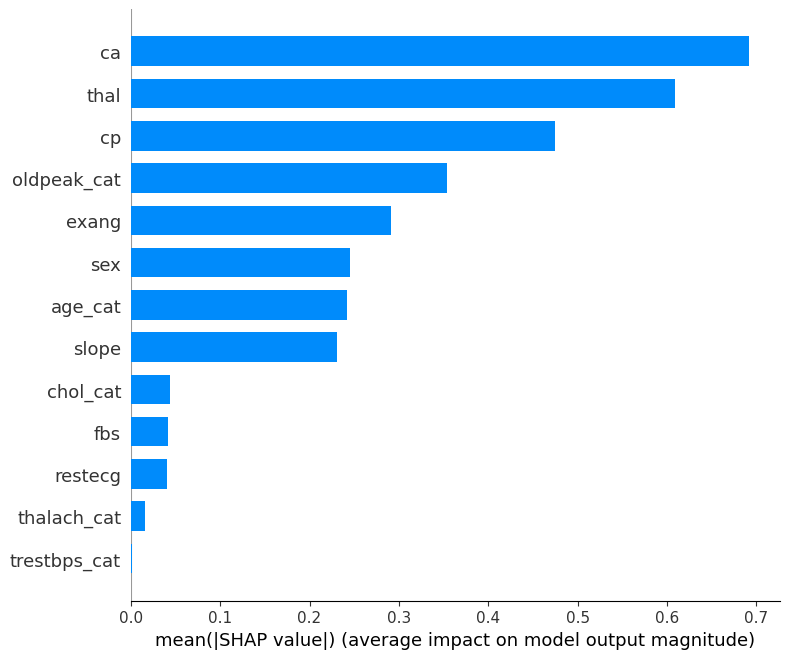

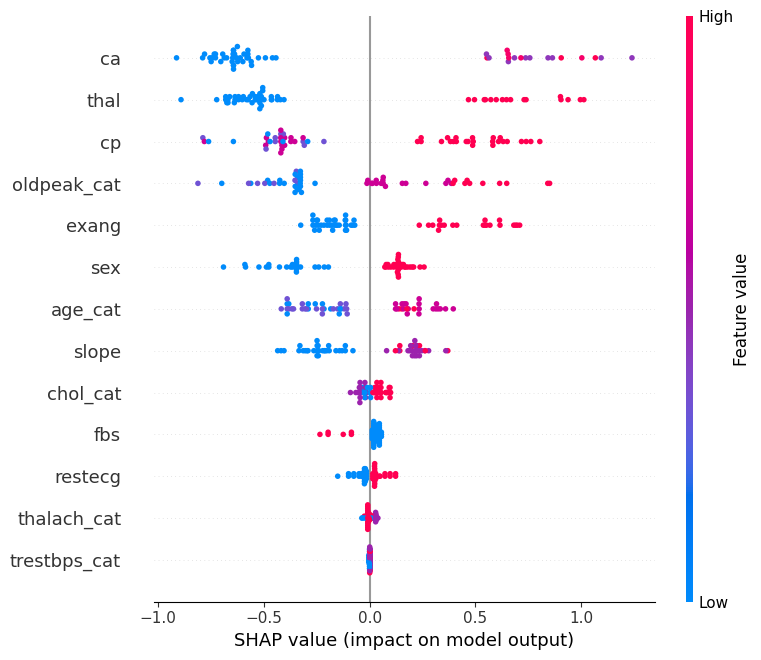

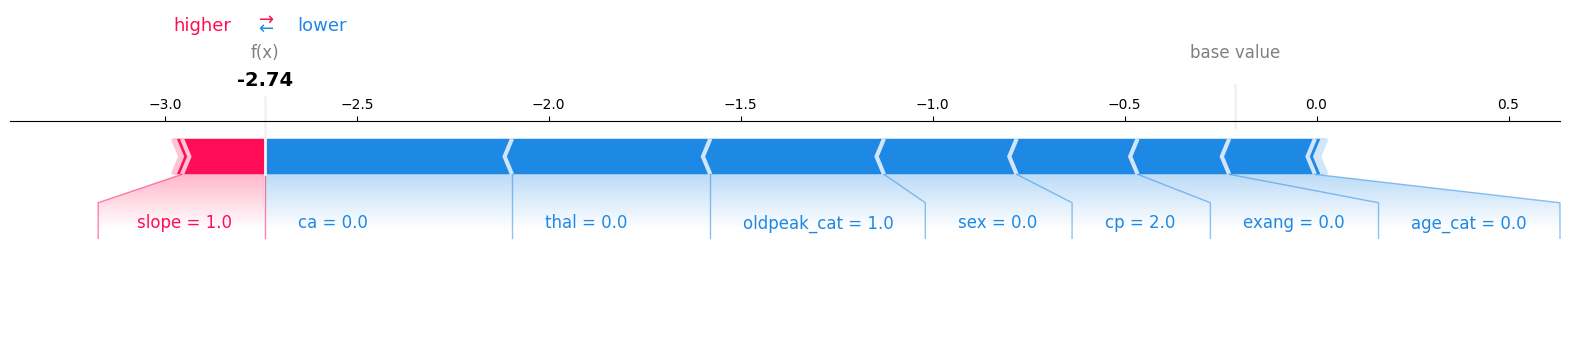

In [ ]:
import shap

explainer = shap.TreeExplainer(xgb_best)
shap_values = explainer.shap_values(X_test_imputed)

shap.summary_plot(
    shap_values,
    X_test_imputed,
    feature_names=X.columns,
    plot_type="bar",
    show=True
)

shap.summary_plot(
    shap_values,
    X_test_imputed,
    feature_names=X.columns,
    show=True
)

shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_values[i],
    X_test_imputed[i],
    feature_names=X.columns,
    matplotlib=True
)